In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/Users/ashabanov/code/metric_learning/open-metric-learning")

from IPython.core.display import HTML
from IPython.display import display
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import torch
import matplotlib.pyplot as plt

from oml.datasets.base import BaseDataset
from oml.models.vit.vit import ViTExtractor
from oml.transforms.images.torchvision.transforms import get_normalisation_resize_hypvit
from oml.transforms.images.utils import get_im_reader_for_transforms
from oml.metrics.embeddings import EmbeddingMetrics
from oml.postprocessors.pairwise_embeddings import PairwiseEmbeddingsPostprocessor
from oml.samplers.balance import BalanceSampler
from oml.miners.inbatch_all_tri import AllTripletsMiner
from oml.utils.misc_torch import elementwise_dist

from source import TensorsWithLabels

display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 330)

%matplotlib inline


In [2]:
dataset_root = Path("/nydl/data/Stanford_Online_Products/")
weights = "vits16_sop"

if False:  # save features
    batch_size = 1024

    df = pd.read_csv(dataset_root / "df.csv")

    transform = get_normalisation_resize_hypvit(im_size=224, crop_size=224)
    im_reader = get_im_reader_for_transforms(transform)

    dataset = BaseDataset(df=df, transform=transform, f_imread=im_reader)
    model = ViTExtractor(weights, arch=weights.split("_")[0], normalise_features=True).eval().cuda()
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=20)

    embeddings = torch.zeros((len(df), model.feat_dim))

    with torch.no_grad():
        for i, batch in enumerate(tqdm(train_loader)):
            embs = model(batch["input_tensors"].cuda()).detach().cpu()
            ia = i * batch_size
            ib = min(len(embeddings), (i + 1) * batch_size)
            embeddings[ia:ib, :] = embs

    torch.save(embeddings, dataset_root / f"embeddings_{weights}.pkl")
    
    

def get_datasets():
    embeddings = torch.load(dataset_root / f"embeddings_{weights}.pkl")
    df = pd.read_csv(dataset_root / "df.csv")
    train_mask = df["split"] == "train"
    
    emb_train = embeddings[train_mask]
    emb_val = embeddings[~train_mask]
    
    df_train = df[train_mask]
    df_train.reset_index(inplace=True)
    
    df_val = df[~train_mask]
    df_val.reset_index(inplace=True)

    return emb_train, emb_val, df_train, df_val


emb_train, emb_val, df_train, df_val = get_datasets()


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):


In [3]:
class AllPairsMiner:
    
    def __init__(self):
        self.miner = AllTripletsMiner()
        
    def sample(self, features, labels):
        ii_a, ii_p, ii_n = self.miner._sample(None, labels=labels)
        ii_a, ii_p, ii_n = zip(*sorted(list(set(zip(ii_a, ii_p, ii_n)))))
        
        # leave only unique pairs
        ii_a, ii_p = zip(*sorted(list(set(tuple(zip(ii_a, ii_p))))))
        ii_a, ii_n = zip(*sorted(list(set(tuple(zip(ii_a, ii_n))))))
        
        gt_distance = torch.zeros(2 * len(ii_a)).bool()
        gt_distance[len(ii_a):] = True
                
        return features[[*ii_a, *ii_a]], features[[*ii_p, *ii_n]], gt_distance
    
    
miner = AllPairsMiner();
miner.sample(torch.ones((4, 8)), torch.tensor([0, 0, 1, 1]));
miner.sample(torch.ones((4, 8)), torch.tensor([0, 0, 1, 1]));
miner.sample(torch.ones((4, 8)), torch.tensor([0, 0, 1, 1]));


/nydl/code/open-metric-learning/oml/miners/inbatch_all_tri.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, device=device, requires_grad=False)


In [23]:
class Siamese(torch.nn.Module):

    def __init__(self, feat_dim: int, identity_init: bool):
        super(Siamese, self).__init__()
        self.feat_dim = feat_dim

        self.proj1 = torch.nn.Sequential(*[
            torch.nn.Linear(feat_dim, feat_dim, bias=True),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(feat_dim, 1),
        ])
        
        self.proj2 = torch.nn.Sequential(*[
            torch.nn.Linear(feat_dim, feat_dim, bias=True),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(feat_dim, 1),
        ])
        
        self.proj12 = torch.nn.Sequential(*[
            torch.nn.Linear(2 * feat_dim, 2 * feat_dim, bias=True),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(2 * feat_dim, 1),
        ])
        
#         self.w = torch.nn.Parameter(data=torch.tensor([0.0]))
        
#         if identity_init:
#             ini_dict = {"weight": torch.eye(feat_dim), "bias": torch.zeros(feat_dim)}
#             self.proj1.load_state_dict(ini_dict)
#             self.proj2.load_state_dict(ini_dict)


    def forward(self, x1, x2):
        d0 = 1 - (x1 * x2).sum(dim=1)
        
        d1 = self.proj1(x1)
        d2 = self.proj2(x2) 
        d12 = self.proj12(torch.cat([x1, x2], dim=1))
        
        return d0 + d1 + d2 + d12
    
    
y = Siamese(3, True)(torch.tensor([[0.0, 1, 0]]), torch.tensor([[0.0, 0, 1]]))
print(y)


tensor([[1.3611]], grad_fn=<AddBackward0>)


In [24]:
# Training
model = Siamese(feat_dim=384, identity_init=True)
model.cuda().train()

dataset = TensorsWithLabels(df_train, emb_train)

n_labels, n_instances = 2, 2
loader = torch.utils.data.DataLoader(
    batch_sampler=BalanceSampler(labels=dataset.get_labels(), n_labels=n_labels, n_instances=n_instances),
    dataset=dataset
)

b = next(iter(loader))
batches = [b] * 900

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)

pairs_miner = AllPairsMiner()
criterion = torch.nn.MSELoss(reduction="mean")

losses = []
acc = []

for _ in range(1):
    tqdm_loader = tqdm(batches)
    for batch in tqdm_loader:
        x1, x2, gt_dist = pairs_miner.sample(batch["input_tensors"], batch["labels"])
        x1, x2, gt_dist = x1.cuda(), x2.cuda(), gt_dist.cuda()

        pred_dist = model(x1=x1, x2=x2)   
        loss = criterion(pred_dist, gt_dist.float())
                
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # logs
        accuracy = ((pred_dist > 0.5) == gt_dist).float().mean().item()
        tqdm_loader.set_postfix({"acc": accuracy, "loss": loss.item()})
        losses.append(loss.item())
        acc.append(accuracy)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:03<00:00, 230.33it/s, acc=0.5, loss=0.307]


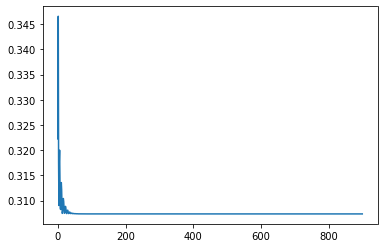

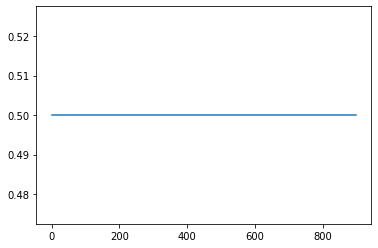

In [25]:
plt.plot(losses)
plt.show()
plt.plot(acc)
plt.show()

In [ ]:
# Validation with postprocessing
# model = Siamese(384, True).cuda() # <-- note

processor = PairwiseEmbeddingsPostprocessor(model, top_n=5)

calculator = EmbeddingMetrics(
    cmc_top_k=(1, 5, 10),
    postprocessor=processor
)
calculator.setup(len(df_val))
calculator.update_data({
    "embeddings": emb_val,
    "is_query": torch.tensor(df_val["is_query"]).bool(),
    "is_gallery": torch.tensor(df_val["is_gallery"]).bool(),
    "labels": torch.tensor(df_val["label"]).long()
})
metrics = calculator.compute_metrics();
